In [51]:
import os
import hashlib
import shutil
import tensorflow as tf
import numpy as np


def predict_and_correct_images(input_dir, model, family_labels, genus_labels, species_labels, output_path, family_threshold=0.7, genus_threshold=0.7, species_threshold=0.7):
    """
    Predict and organize images by taxonomic hierarchy, correcting misclassifications based on taxonomy map.
    
    Args:
    - input_dir (str): Directory containing images for prediction.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - output_path (str): Root directory path to store organized images.
    - family_threshold (float): Confidence threshold for family-level classification.
    - genus_threshold (float): Confidence threshold for genus-level classification.
    - species_threshold (float): Confidence threshold for species-level classification.
    """
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    image_paths = [
        os.path.join(input_dir, fname) 
        for fname in os.listdir(input_dir) 
        if not fname.startswith(".") and fname.lower().endswith(valid_extensions)
    ]

    def predict_top_label(predictions, labels, threshold):
        top_index = np.argmax(predictions)
        top_label = labels[top_index]
        top_confidence = predictions[top_index]
        return (top_label, top_confidence) if top_confidence >= threshold else ("unknown", None)

    for image_path in image_paths:
        # Load and preprocess the image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.expand_dims(img, 0)

        # Predict family, genus, and species
        family_pred, genus_preds, species_preds = model.predict(img)

        # Predict family
        family, family_conf = predict_top_label(family_pred[0], family_labels, family_threshold)
        family = family.decode('utf-8') if isinstance(family, bytes) else family

        # Predict genus and validate against family
        genus, genus_conf = predict_top_label(genus_preds[0], genus_labels, genus_threshold)
        genus = genus.decode('utf-8') if isinstance(genus, bytes) else genus
        if family != "unknown" and (genus == "unknown" or genus not in taxonomy_map.get(family, {})):
            genus = "unknown"

        # Predict species and validate against genus
        species, species_conf = predict_top_label(species_preds[0], species_labels, species_threshold)
        species = species.decode('utf-8') if isinstance(species, bytes) else species
        if genus != "unknown" and (species == "unknown" or species not in taxonomy_map.get(family, {}).get(genus, [])):
            species = "unknown"

        # Define the directory structure based on corrected predictions
        family_dir = os.path.join(output_path, family)
        genus_dir = os.path.join(family_dir, genus)
        species_dir = os.path.join(genus_dir, species)

        # Ensure directory path exists for "unknown" placements at any level
        os.makedirs(species_dir, exist_ok=True)

        # Calculate score prefix and generate unique filename
        score_prefix = int((species_conf if species_conf is not None else 0) * 1000)
        hash_str = hashlib.md5(image_path.encode()).hexdigest()[:5]
        file_name = f"{score_prefix}_{species}_{hash_str}.jpeg"
        save_path = os.path.join(species_dir, file_name)

        # Copy image to the appropriate directory
        shutil.copy(image_path, save_path)
        print(f"Saved {image_path} to {save_path}")

# Example usage
# predict_and_correct_images(input_dir="path_to_images", model=model, family_labels=family_labels, genus_labels=genus_labels, species_labels=species_labels, output_path="classified_images")

In [28]:
model = tf.keras.models.load_model('/Users/leonardo/Documents/Projects/cryptovision/models/hacpl_rn50v2_mo_antropic_classifier.keras')

In [29]:
import pandas as pd

def image_directory_to_pandas(image_path):
    """
    Create a pandas DataFrame with image paths and taxonomic labels extracted from a directory structure.

    Parameters:
    ----------
    image_path : str
        The root directory containing subfolders with images.

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing image paths and label information. Columns include:
        - 'path': The full path to the image.
        - 'folder_label': The folder name, representing the original label (format: 'family_genus_species').
        - 'family': Extracted family name from the folder label.
        - 'genus': Extracted genus name from the folder label.
        - 'species': Combination of genus and species names (e.g., 'genus species').

    Raises:
    ------
    ValueError:
        If the folder label format does not match the expected 'family_genus_species' format.
    """
    labels = []
    paths = []

    # Walk through the directory and collect image paths and labels
    for root_dir, _, filenames in os.walk(image_path):
        for filename in filenames:
            # Ignore hidden files and non-image files
            if filename.startswith('.') or os.path.splitext(filename)[1].lower() not in {".jpeg", ".png", ".jpg"}:
                continue

            # Extract the folder name as the label, ignoring 'GT' directories
            folder_label = os.path.basename(root_dir)
            if folder_label != "GT":
                labels.append(folder_label)
                paths.append(os.path.join(root_dir, filename))

    # Create DataFrame with paths and folder labels
    df = pd.DataFrame({'image_path': paths, 'folder_label': labels})
    df['folder_label'] = df['folder_label'].astype("category")

    # Split the folder_label into 'family', 'genus', and 'species'
    try:
        df[['family', 'genus', 'species']] = df['folder_label'].str.split("_", expand=True)
        df['species'] = df['genus'] + " " + df['species']
    except ValueError as e:
        raise ValueError(
            "Error splitting folder labels. Ensure that your folder structure follows 'family_genus_species' format."
        ) from e

    # Return the dataframe with specified columns
    return df[['image_path', 'folder_label', 'family', 'genus', 'species']]

df = image_directory_to_pandas("/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset")

In [30]:
 # Extract the unique family, genus, and species from the dataframe
family_labels = sorted(df['family'].unique())
genus_labels = sorted(df['genus'].unique())
species_labels = sorted(df['species'].unique())

# Convert family, genus, and species labels to TensorFlow tensors
family_labels = tf.constant(family_labels)
genus_labels = tf.constant(genus_labels)
species_labels = tf.constant(species_labels)

family_labels = family_labels.numpy().tolist()
genus_labels = genus_labels.numpy().tolist()
species_labels = species_labels.numpy().tolist()

In [53]:
import pandas as pd
from collections import defaultdict

def create_taxonomic_map(df):
    """
    Create a taxonomic map from a DataFrame with family, genus, and species columns.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'family', 'genus', and 'species' columns with correct hierarchical relationships.
    
    Returns:
    - dict: A nested dictionary with the structure {family: {genus: [species, ...], ...}, ...}
    """
    taxonomic_map = defaultdict(lambda: defaultdict(set))

    # Iterate over each row in the DataFrame to build the hierarchy
    for _, row in df.iterrows():
        family = row['family']
        genus = row['genus']
        species = row['species']
        
        # Add species under the correct family and genus
        taxonomic_map[family][genus].add(species)
    
    # Convert sets to lists for easier use and consistency in format
    taxonomic_map = {family: {genus: list(species_set) for genus, species_set in genera.items()}
                     for family, genera in taxonomic_map.items()}
    
    return taxonomic_map


taxonomy_map = create_taxonomic_map(df)


# Example usage:
# Assuming df is your training DataFrame with columns 'family', 'genus', and 'species'
# taxonomic_map = create_taxonomic_map(df)
# print(taxonomic_map)

In [54]:
predict_and_correct_images(
    '/Volumes/T7_shield/CryptoVision/Data/others/chris_images copy', 
    model, 
    family_labels, 
    genus_labels, 
    species_labels, 
    '/Volumes/T7_shield/CryptoVision/Data/others/chris_images_organized', 
    family_threshold=0.4, 
    genus_threshold=0.4, 
    species_threshold=0.4
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved /Volumes/T7_shield/CryptoVision/Data/others/chris_images copy/LIRS23_0265.JPG to /Volumes/T7_shield/CryptoVision/Data/others/chris_images_organized/Gobiidae/unknown/unknown/0_unknown_92ace.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved /Volumes/T7_shield/CryptoVision/Data/others/chris_images copy/LIRS23_0503.JPG to /Volumes/T7_shield/CryptoVision/Data/others/chris_images_organized/Gobiidae/Priolepis/Priolepis semidoliatus/698_Priolepis semidoliatus_512be.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved /Volumes/T7_shield/CryptoVision/Data/others/chris_images copy/LIRS23_0517.JPG to /Volumes/T7_shield/CryptoVision/Data/others/chris_images_organized/Gobiidae/unknown/Cypho purpurascens/735_Cypho purpurascens_cbebf.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved /Volumes/T7_shield/CryptoVision/Data/others/chris_images copy/LIRS23_0271.JPG to /Volumes/T7_shield/CryptoVision/Data/others/chris_images_organized/Gobiidae/unknown/unknown/0_unknown_c

In [23]:
def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

In [ ]:
def classfier_organizer(input_folder):
    
    # Loop through each image in the input folder
    for img_name in os.listdir(input_folder):
        img_path = os.path.join(input_folder, img_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


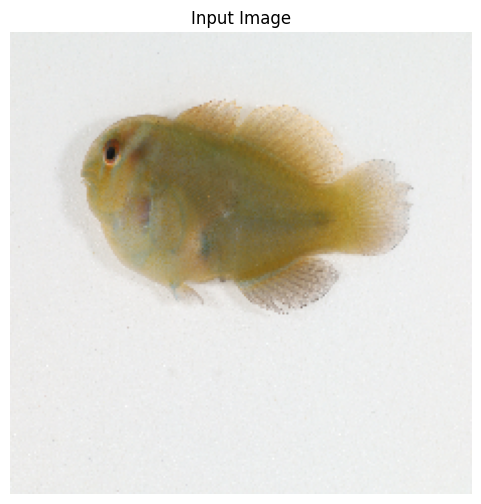

Top 3 Family Predictions:
b'Scorpaenidae': 0.5247
b'Gobiidae': 0.4733
b'Blenniidae': 0.0012

Top 3 Genus Predictions:
b'Caracanthus': 0.4575
b'Paragobiodon': 0.3175
b'Gobiodon': 0.2101

Top 3 Species Predictions:
b'Caracanthus unipinna': 0.8966
b'Paragobiodon modestus': 0.0762
b'Gobiodon quinquestrigatus': 0.0229


In [25]:
import matplotlib.pyplot as plt

top_k_family, top_k_genus, top_k_species = predict_image(
    '/Volumes/T7_shield/CryptoVision/Data/others/chris_images_organized/Gobiidae/Pleurosicya/Pleurosicya labiata/64_Pleurosicya labiata_Pleurosicya_Gobiidae_37bca.jpeg',
    model,
    family_labels, genus_labels, species_labels,
    (229,229)
)

In [18]:
# Load and preprocess the image
img = tf.io.read_file('/Volumes/T7_shield/CryptoVision/Data/others/chris_images_organized/Gobiidae/Pleurosicya/Pleurosicya labiata/64_Pleurosicya labiata_Pleurosicya_Gobiidae_37bca.jpeg')
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (299, 299))
img = tf.expand_dims(img, 0)  # Add batch dimension

# Predict family, genus, and species
family_pred, genus_preds, species_preds = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [19]:
family_pred.max()

0.9318132